In [1]:
%load_ext autoreload
%autoreload 2

The test that compares two different ways of enumerating products in `tests/test_dist_enum.py`.

In [2]:
from pathlib import Path

import asf_search as asf
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pandas.testing import assert_frame_equal
from rasterio.crs import CRS
from shapely.geometry import Point
from tqdm import tqdm

from dist_s1_enumerator.mgrs_burst_data import (
    get_burst_ids_in_mgrs_tiles,
    get_burst_table,
    get_burst_table_from_mgrs_tiles,
    get_mgrs_tile_table_by_ids,
    get_mgrs_tiles_overlapping_geometry,
)

In [21]:
# point = Point(-46, 71) # Greenaland
point = Point(-118, 34).buffer(0.25)  # Los Angeles
df_aoi = gpd.GeoDataFrame(geometry=[point], crs=CRS.from_epsg(4326))
df_mgrs_tiles = get_mgrs_tiles_overlapping_geometry(point)
df_mgrs_tiles.head()

,mgrs_tile_id,utm_epsg,utm_wkt,geometry
0,11SLT,32611,"MULTIPOLYGON(((300000 3800040,300000 3690240,4...","POLYGON ((-119.17378 34.32237, -119.14887 33.3..."
1,11SLU,32611,"MULTIPOLYGON(((300000 3900000,300000 3790200,4...","POLYGON ((-119.19754 35.22312, -119.1715 34.23..."
2,11SMT,32611,"MULTIPOLYGON(((399960 3800040,399960 3690240,5...","POLYGON ((-118.08758 34.33683, -118.07511 33.3..."
3,11SMU,32611,"MULTIPOLYGON(((399960 3900000,399960 3790200,5...","POLYGON ((-118.09948 35.23808, -118.08644 34.2..."


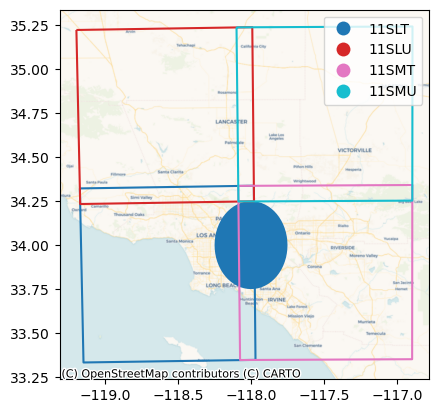

In [22]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.geometry = df_mgrs_tiles_plot.geometry.boundary
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, legend=True, ax=ax
)
df_aoi.plot(ax=ax)
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)

In [23]:
mgrs_tile_ids = ["11SLT", "11SLU", "11SMT"]

In [24]:
df_bursts = get_burst_table_from_mgrs_tiles(mgrs_tile_ids)
df_bursts.head()

,jpl_burst_id,track_number,acq_group_id_within_mgrs_tile,mgrs_tile_id,geometry
0,T064-135513-IW2,64,0,11SMT,"POLYGON ((-117.71812 33.04661, -116.76014 33.1..."
1,T064-135514-IW1,64,0,11SMT,"POLYGON ((-118.62403 33.01064, -117.71207 33.1..."
2,T064-135514-IW2,64,0,11SMT,"POLYGON ((-117.75466 33.2127, -116.79478 33.35..."
3,T064-135515-IW1,64,0,11SLT,"POLYGON ((-118.66236 33.17675, -117.74859 33.3..."
4,T064-135515-IW1,64,0,11SMT,"POLYGON ((-118.66236 33.17675, -117.74859 33.3..."


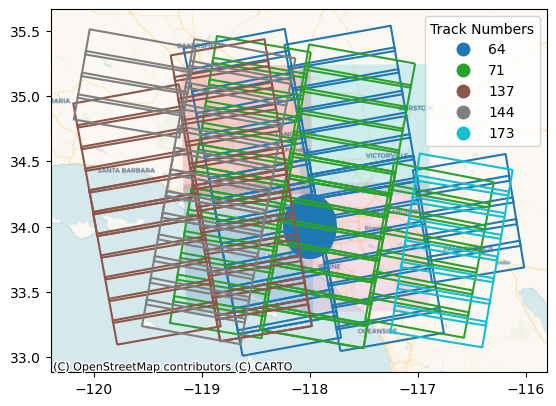

In [25]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, ax=ax, alpha=0.2
)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot.plot(column="track_number", categorical=True, ax=ax, legend=True)
leg = ax.get_legend()
leg.set_title("Track Numbers")
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)

In [26]:
delta_window_days = 365
delta_lookback_days = 0
max_pre_imgs_per_burst = 10

# Example test

In [27]:
from dist_s1_enumerator.asf import get_rtc_s1_ts_metadata_from_mgrs_tiles
from dist_s1_enumerator.dist_enum import (
    enumerate_dist_s1_products,
    enumerate_one_dist_s1_product,
)

In [30]:
track_numbers = None

In [31]:
df_ts = get_rtc_s1_ts_metadata_from_mgrs_tiles(
    mgrs_tile_ids, track_numbers=track_numbers
)
df_ts.head()

,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token
0,OPERA_L2_RTC-S1_T064-135515-IW1_20220101T01502...,T064-135515-IW1,2022-01-01 01:50:26+00:00,2022-01-01,VV+VH,64,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.66111 33.18146, -117.72758 33.3...",11SLT,0,64
1,OPERA_L2_RTC-S1_T064-135516-IW1_20220101T01502...,T064-135516-IW1,2022-01-01 01:50:29+00:00,2022-01-01,VV+VH,64,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.69949 33.34746, -117.76409 33.4...",11SLT,0,64
2,OPERA_L2_RTC-S1_T064-135517-IW1_20220101T01503...,T064-135517-IW1,2022-01-01 01:50:32+00:00,2022-01-01,VV+VH,64,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.738 33.5137, -117.79867 33.6606...",11SLT,0,64
3,OPERA_L2_RTC-S1_T064-135518-IW1_20220101T01503...,T064-135518-IW1,2022-01-01 01:50:35+00:00,2022-01-01,VV+VH,64,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.7765 33.67956, -117.83665 33.82...",11SLT,0,64
4,OPERA_L2_RTC-S1_T064-135519-IW1_20220101T01503...,T064-135519-IW1,2022-01-01 01:50:37+00:00,2022-01-01,VV+VH,64,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.81521 33.84603, -117.87108 33.9...",11SLT,0,64


In [32]:
df_ts.track_number.unique()

array([ 64,  71, 137, 144, 173])

In [33]:
data_dir = Path("rtc_s1_ts_metadata")
data_dir.mkdir(exist_ok=True, parents=True)

mgrs_tile_token = "_".join(mgrs_tile_ids)
file_name = f"mgrs{mgrs_tile_token}.parquet"
if track_numbers is not None:
    track_token = "_".join(list(map(str, track_numbers)))
    file_name = file_name.replace(".parquet", "__track{track_token}.parquet")
df_ts.to_parquet(data_dir / file_name)

In [34]:
df_products = enumerate_dist_s1_products(df_ts, mgrs_tile_ids)
df_products.head()

Enumerating by MGRS tiles: 100%|█████████████████| 3/3 [00:00<00:00,  3.22it/s]


,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,input_category,product_id
0,OPERA_L2_RTC-S1_T064-135515-IW1_20240818T01503...,T064-135515-IW1,2024-08-18 01:50:35+00:00,2024-08-18,VV+VH,64,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.6612 33.1808, -117.70845 33.330...",11SLT,0,64,pre,0
1,OPERA_L2_RTC-S1_T064-135516-IW1_20240818T01503...,T064-135516-IW1,2024-08-18 01:50:37+00:00,2024-08-18,VV+VH,64,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.6996 33.34692, -117.74409 33.49...",11SLT,0,64,pre,0
2,OPERA_L2_RTC-S1_T064-135517-IW1_20240818T01504...,T064-135517-IW1,2024-08-18 01:50:40+00:00,2024-08-18,VV+VH,64,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.7381 33.51317, -117.77948 33.66...",11SLT,0,64,pre,0
3,OPERA_L2_RTC-S1_T064-135518-IW1_20240818T01504...,T064-135518-IW1,2024-08-18 01:50:43+00:00,2024-08-18,VV+VH,64,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.77665 33.67927, -117.81609 33.8...",11SLT,0,64,pre,0
4,OPERA_L2_RTC-S1_T064-135519-IW1_20240818T01504...,T064-135519-IW1,2024-08-18 01:50:46+00:00,2024-08-18,VV+VH,64,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-118.81529 33.8455, -117.85175 33.99...",11SLT,0,64,pre,0


In [43]:
df_post = df_products[df_products.input_category == "post"].reset_index(
    drop=True
)
df_tmp = (
    df_post[
        [
            "product_id",
            "acq_date_for_mgrs_pass",
            "track_number",
            "mgrs_tile_id",
            "track_token",
        ]
    ]
    .drop_duplicates(subset="product_id")
    .sort_values(by="acq_date_for_mgrs_pass")
)
mgrs_tile_ids_post = df_tmp["mgrs_tile_id"].tolist()
product_ids = df_tmp["product_id"].tolist()
post_dates = df_tmp["acq_date_for_mgrs_pass"].tolist()
track_tokens_post = df_tmp["track_token"].tolist()
track_numbers_post_lst = [
    [int(track) for track in token.split("_")] for token in track_tokens_post
]

In [45]:
for mgrs_tile_id_post, product_id, track_numbers_post, post_date in tqdm(
    zip(mgrs_tile_ids_post, product_ids, track_numbers_post_lst, post_dates),
    total=len(post_dates),
):
    df_one_product = enumerate_one_dist_s1_product(
        mgrs_tile_id_post,
        track_number=track_numbers_post,
        post_date=pd.Timestamp(post_date),
    )
    df_one_product_alt = (
        df_products[df_products.product_id == product_id]
        .reset_index(drop=True)
        .drop(columns="product_id")
    )
    df_pre_alt = df_one_product_alt[
        df_one_product_alt.input_category == "pre"
    ].reset_index(drop=True)
    df_post_alt = df_one_product_alt[
        df_one_product_alt.input_category == "post"
    ].reset_index(drop=True)

    df_pre = df_one_product[df_one_product.input_category == "pre"].reset_index(
        drop=True
    )
    df_post = df_one_product[
        df_one_product.input_category == "post"
    ].reset_index(drop=True)

    assert_frame_equal(df_pre, df_pre_alt, atol=1e-7)
    assert_frame_equal(df_post, df_post, atol=1e-7)
    break

  0%|                                                  | 0/410 [00:02<?, ?it/s]
